# Smart Irrigation Analysis

Six months ago I purchased a smart irrigation device (henceforth referred to as IOT).  The ultimate goal was to save money, while also better managing the health of landscaping.

The existing irrigation device had a rain sensor but it only works if it's raining at the time the system was running.  If it stopped raining right before the system came on it did no good.  It was unaware that we just got 6 feet of rain.  I exagerate a little, but you get the idea.

The iot device would know if it had just rained and therefore it could skip it's watering schedule.  All hail technology!  The device was purchased for $212, including tax.

A couple caveats to this data set:

1. While using the existing irrigation device, I would manually toggle it off/on when I knew it was going to rain enough to skip watering.  While I tried to be as diligent about this as I could manual processes are prone to error.  If I had not done this the water usage would have been almost constant.
1. I used the crude analysis of a constant water schedule to guesstimate my ROI before I made the purchase.  I don't recall exactly what I estimated the ROI to be but I do remember that it would pay for itself rather quickly.
1. The existing irrigation device, while it would put out a significant amount of water barely kept the landscaping alive.  It was a struggle to get it to work adequately, which also led to the IOT device purchase.
1. The IOT device is configured to water more frequently, assuming no rain, to keep the landcaping from dieing.  However, in the six months of having it we've had a lot more rain than usual.  This may skew the results for now becuase there is not a lot of IOT data to work with.  Keep this in mind.

So was it worth it?  Lets find out.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tseries.offsets import MonthEnd, MonthBegin

%matplotlib inline

## Read in data

The data was sourced from two locations:

1. Irrigation data was manually extracted from utility bill for last 25 months.
   1. Inference was made to get the gallons consumed using the price charged based on rates listed.  Gallons consumed is not explicilty line itemed.
1. Weather data was manually copied from wunderground.com historical information (API is no longer free).


In addition to reading in the data, remove some columns that aren't used in the analysis.


In [2]:
# Read in the data
irrigation_df = pd.read_csv('irrigation_usage.csv')
weather_df = pd.read_csv('weather_data.csv')

In [3]:
irrigation_df.head()

,period_start,period_end,consumed_gallons,monthly_flat_fee,inspection_fee,tier_1_kgal_rate_(1-14),tier_2_kgal_rate_(>14),consumption_charge,environmental_fee,total_charge
0,8/12/2016,9/14/2016,36000,18.9,6.0,2.6,5.6,159.6,13.32,197.82
1,9/14/2016,10/13/2016,18000,18.9,6.0,2.6,5.6,58.8,6.66,90.36
2,10/13/2016,11/14/2016,35000,18.9,6.0,2.6,5.6,154.0,12.95,191.85
3,11/14/2016,12/14/2016,28000,18.9,6.0,2.6,5.6,114.8,10.36,150.06
4,12/14/2016,1/17/2017,39000,18.9,6.0,2.6,5.6,176.4,14.43,215.73


In [4]:
weather_df.head()

,month,max_temp,avg_temp,min_temp,total_rain_inches
0,Jan-16,73,55,30,2.07
1,Feb-16,84,59,36,3.10
2,Mar-16,89,70,46,2.33
3,Apr-16,91,73,55,2.99
4,May-16,96,79,55,3.76


In [5]:
#  The rates are always the same in the dataset so we'll take them out and shove it into a function for later use
irrigation_df[['tier_1_kgal_rate_(1-14)','tier_2_kgal_rate_(>14)']].nunique(axis=0)

tier_1_kgal_rate_(1-14)    1
tier_2_kgal_rate_(>14)     1
dtype: int64

## Start Transforms

### Create a couple helper functions

A couple functions that are part of the analysis.

1. Calculate the charge based on the gallons consumed
1. Get the polynomial from the trend line

In [6]:
# Create a function to calculate the charge using the rates above.
#
def consumption_charge(gal):
    """
    INPUT
    gal - integer
    
    OUTPUT
    integer - calculated charge from input gallons
    """
    if gal <= 14000:
        return gal*2.6/1000
    return ((14000*2.6)+((gal-14000)*5.6))/1000

# calc the trendline (it is simply a linear fitting)
#
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html
def getPoly(z, x, y, deg=1):
    """
    INPUT
    z - integer - x-coordinate to predict y
    x - array_like - x-coordinates of sample data
    y - array_like - y-coordinates of sample data
    deg - degree of the fitting polynomial
    
    OUTPUT
    integer - predicted y-coordinate
    """
    pf = np.polyfit(x, y, deg)
    pd = np.poly1d(pf)
    rsp = pd(z)
    return rsp

### Data Alignment

The irrigation data does not line up with the month start/end like the weather data does.  The irrigation data has to be realligned to the month so the data sets match and can be joined.

#### Processing Steps

##### Weather Data

1. Convert inches of rain to gallons of rain.  Calculation is based on my estimated lot size.

##### Irrigation Data

1. Drop rate data since it was pushed into a function above
1. Get the number of days in the period
1. Calculate gallons per day
1. Get month start/end dates
1. Split each row into two rows
   1. period_start to end of month
   1. start of month to period_end
1. Recalculate consumed_gallons based on new date ranges of each row
1. Group data by month
1. Recalculate total_charge based on new consumued_gallons

###### Joined Data

1. Join irrigation and weather data
1. Add indicator of smart device use
1. Add kilogallons (kgal) for consumed and rain
1. Add text values for month, year, and month_year for graphing
1. Scale the kgal values to 0-1 range
1. Calculate percent of irrigation from rain

In [7]:
# The irrigation data needs to be re-aligned to the month
#   This is accomplished by determining water p/day and then rolling up the rows into months

def dataCleanse(weather_df, irrigation_df):
    '''
    INPUT
    weather_df - pandas dataframe 
    irrigation_df - pandas dataframe
    
    OUTPUT
    pandas dataframe - consisting of both input dataframes combined, aligned and cleansed
    '''
    
    # Convert the date fields into datetime datatypes
    irrigation_df['period_start'] = pd.to_datetime(irrigation_df['period_start'])
    irrigation_df['period_end'] = pd.to_datetime(irrigation_df['period_end'])
    weather_df['month'] = pd.to_datetime(weather_df['month'], format='%b-%y')

    # Remove all the fee columns, not intersted in them
    irrigation_df = irrigation_df.drop(['monthly_flat_fee','inspection_fee','environmental_fee','total_charge'], axis=1)

    # Remove the temp columns
    weather_df = weather_df.drop(['max_temp','avg_temp','min_temp'], axis=1)

    # Convert 'rain inches' into gallons
    # http://prwcd.org/water_conv.html
    #    1 inch of rain on 1 acre = 27154 gallons of water
    # Lot size is .36 acres with about half being yard.
    weather_df['rain_gallons'] = weather_df['total_rain_inches'] *(27154*.36/2)

    # The rates are hardcoded into the function above, this won't work if the rates ever change but for now it's fine.
    #  Why create work for something that may not happen.
    irrigation_df.drop(['tier_1_kgal_rate_(1-14)','tier_2_kgal_rate_(>14)'], axis=1, inplace=True)

    # https://stackoverflow.com/questions/22132525/add-column-with-number-of-days-between-dates-in-dataframe-pandas
    irrigation_df['period_days'] = (irrigation_df['period_end'] - irrigation_df['period_start']).dt.days

    irrigation_df['gallons_day'] = irrigation_df['consumed_gallons'] / irrigation_df['period_days']

    # Get the month start/end of the periods in the record
    # https://stackoverflow.com/questions/37354105/find-the-end-of-the-month-pandas-dataframe-series
    irrigation_df['period_start_end'] = irrigation_df['period_start'] + MonthEnd(0)
    irrigation_df['period_end_start'] = irrigation_df['period_end'] + MonthBegin(-1)

    # Use the start/end to break the data into multiple rows
    irrigation_df_1 = irrigation_df[['period_start','period_start_end','gallons_day']].rename(columns={'period_start_end':'period_end'})
    irrigation_df_2 = irrigation_df[['period_end_start','period_end','gallons_day']].rename(columns={'period_end_start':'period_start'})

    # Combine the dataframes and sort for readability
    irrigation_df_split = irrigation_df_1.append(irrigation_df_2, ignore_index=True).sort_values(by='period_start', ascending=True)

    # Set the month for the row
    irrigation_df_split['month'] = irrigation_df_split['period_end'] + MonthBegin(-1)

    # Calculate the consumed gallons based on new date ranges
    irrigation_df_split['consumed_gallons'] = irrigation_df_split['gallons_day'] * (irrigation_df_split['period_end'] - irrigation_df_split['period_start']).dt.days

    # drop columns we don't need anymore
    irrigation_df_split.drop(['period_start','period_end','gallons_day'], inplace=True, axis=1)

    # group the data by month to get the new monthly data
    irrigation_df_new = irrigation_df_split.groupby(['month']).sum().reset_index()

    # calculate the charge per month
    irrigation_df_new['total_charge'] = irrigation_df_new['consumed_gallons'].apply(consumption_charge)

    # Join the two datasets
    combined_df = irrigation_df_new.set_index('month').join(weather_df.set_index('month'), on='month')

    #  add an indicator that smart device was used, 
    combined_df['iot_device'] = combined_df.index > '2018-03-15'
    combined_df['consumed_kgal'] = combined_df.consumed_gallons/1000
    combined_df['rain_kgal'] = combined_df.rain_gallons/1000

    # Add some text values with month/year data for use in graphing
    #   There is probably a better way but I couldn't find it :\
    combined_df['month'] = combined_df.index.month
    combined_df['year'] = combined_df.index.year
    combined_df['month_year'] = combined_df.index.month_name() + ' ' + combined_df['year'].astype(str)

    # Scale the consumed and rain data to have min 0 and max 1
    combined_df['consumed_kgal_scale'] = (combined_df['consumed_kgal'] - combined_df['consumed_kgal'].min()) / (combined_df['consumed_kgal'].max() - combined_df['consumed_kgal'].min())
    combined_df['rain_kgal_scale'] = (combined_df['rain_kgal'] - combined_df['rain_kgal'].min()) / (combined_df['rain_kgal'].max() - combined_df['rain_kgal'].min())

    # Calculate the percentage of water that is rain
    combined_df['percent_from_rain'] = combined_df['rain_kgal'] / (combined_df['rain_kgal'] + combined_df['consumed_kgal'])

    return combined_df


In [8]:
combined_df = dataCleanse(weather_df, irrigation_df)

combined_df

,consumed_gallons,total_charge,total_rain_inches,rain_gallons,iot_device,consumed_kgal,rain_kgal,month,year,month_year,consumed_kgal_scale,rain_kgal_scale,percent_from_rain
month,,,,,,,,,,,,,
2016-08-01,20727.272727,74.072727,2.47,12072.6684,False,20.727273,12.072668,8,2016,August 2016,0.607164,0.234345,0.368070
2016-09-01,24112.852665,93.031975,3.03,14809.7916,False,24.112853,14.809792,9,2016,September 2016,0.729112,0.287476,0.380493
2016-10-01,27135.775862,109.960345,5.91,28886.4252,False,27.135776,28.886425,10,2016,October 2016,0.837998,0.560721,0.515625
2016-11-01,29152.083333,121.251667,0.11,537.6492,False,29.152083,0.537649,11,2016,November 2016,0.910625,0.010436,0.018109
2016-12-01,31633.333333,135.146667,2.22,10850.7384,False,31.633333,10.850738,12,2016,December 2016,1.000000,0.210626,0.255407
2017-01-01,26852.941176,108.376471,0.61,2981.5092,False,26.852941,2.981509,1,2017,January 2017,0.827810,0.057875,0.099935
2017-02-01,16292.857143,49.240000,0.00,0.0000,False,16.292857,0.000000,2,2017,February 2017,0.447436,0.000000,0.000000
2017-03-01,24000.000000,92.400000,1.45,7087.1940,False,24.000000,7.087194,3,2017,March 2017,0.725047,0.137571,0.227978
2017-04-01,29464.285714,123.000000,3.14,15347.4408,False,29.464286,15.347441,4,2017,April 2017,0.921871,0.297913,0.342487


# Begin Analysis

Note: When there is a red line on a chart it indicates the point in time the IOT device was activated.

### Consumed Gallons of Water by Month

Based on this chart alone it seems that the IOT device has decreased water usage.  But I'm sure there is more to the story as the caveats alluded to.

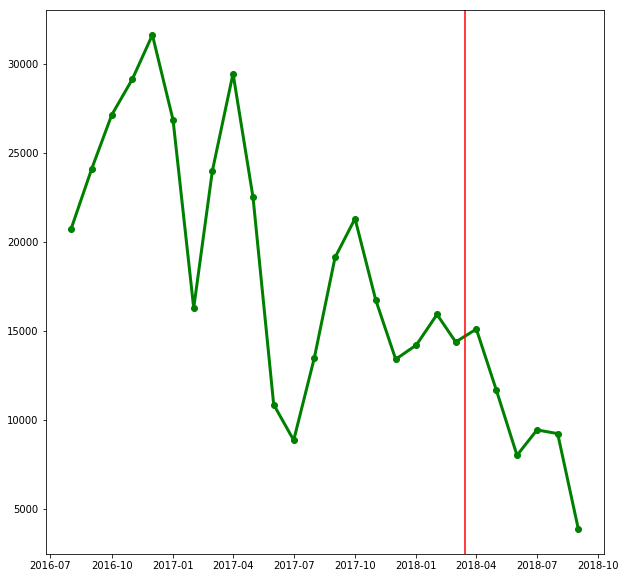

In [9]:
plt.figure(figsize=(10,10))

plt.plot(combined_df.index.to_pydatetime(), combined_df['consumed_gallons'], marker='o', linewidth=3, color='g')
plt.axvline(x=pd.to_datetime('2018-03-15'), ymin=0,ymax=40000, color='r')
plt.show()

### Total Rain (bar) with Consumed Gallons (line)

Using the same consumed gallons line from above and including the rain amounts shows a slightly different story.  Now we see why usage appeared to decrease after the IOT device, more rain.

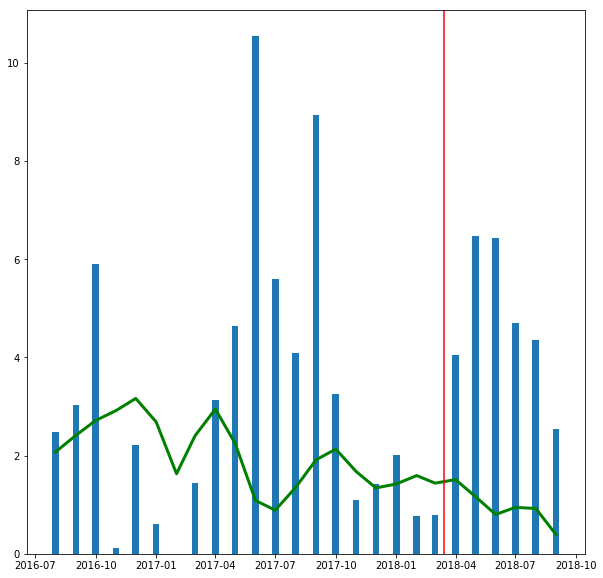

In [10]:
# This is neat but it doesn't seem to be very useful
#  https://stackoverflow.com/questions/47379053/typeerror-ufunc-subtract-cannot-use-operands-with-types-dtypem8ns-and-dt

plt.figure(figsize=(10,10))
plt.bar(combined_df.index.to_pydatetime(), combined_df['total_rain_inches'], width=10)
plt.plot(combined_df.index.to_pydatetime(), combined_df['consumed_kgal']/10, linewidth=3, color='g');
plt.axvline(x=pd.to_datetime('2018-03-15'), ymin=0,ymax=40000, color='r');
plt.show()

### Consumed kgal vs. Rain kgal

There isn't a lot of iot device data but the chart still provides a good picture of what's happening.  Solid line is the trend.

Ideally, as rain goes up consumed gallons should go down, but that isn't always the case.

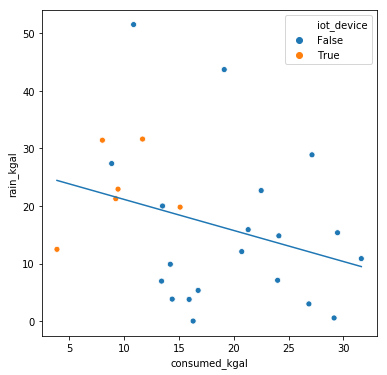

In [11]:
fig, ax = plt.subplots(figsize=(6,6))

sns.scatterplot(x='consumed_kgal', y='rain_kgal', hue='iot_device', data=combined_df, ax=ax)
sns.lineplot(x='consumed_kgal', y=getPoly(combined_df.consumed_kgal, combined_df.consumed_kgal, combined_df.rain_kgal), data=combined_df)
plt.show()

### Percent of irrigation from rain

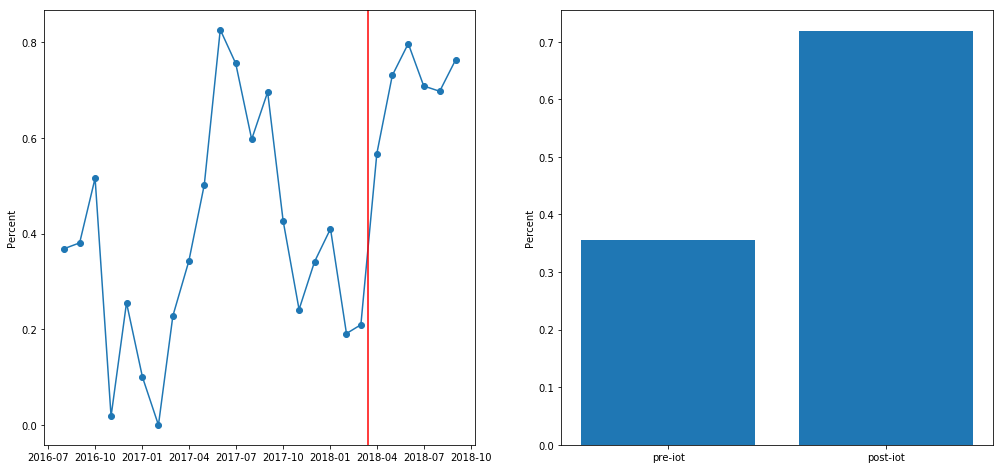

In [12]:
plt.figure(figsize=(17,8))

plt.subplot(121)
plt.plot(combined_df.index.to_pydatetime(), combined_df['percent_from_rain'], marker='o')
plt.axvline(x=pd.to_datetime('2018-03-15'), ymin=0,ymax=40000, color='r')
plt.ylabel('Percent')

plt.subplot(122)
plt.bar(('pre-iot', 'post-iot'), (combined_df[combined_df.iot_device == False].percent_from_rain.median(), combined_df[combined_df.iot_device == True].percent_from_rain.median()))
plt.ylabel('Percent')
plt.show()

### IOT and Surrounding data only

This dataset consists of months with IOT data and corresponding months from non-iot data.  For example, if IOT has data for Sept 2018, then look for non-IOT data from Sept during other years.  In this data it should find Sept. data from 2016 and 2017, for example.

In [13]:
# Just the iot and corresponding data
iot_month_data = combined_df[combined_df.index.month.isin(combined_df[combined_df['iot_device'] == True].index.month)]

# Split based on IOT or not
iot_month_data_isiot = iot_month_data[iot_month_data['iot_device'] == True].copy()
iot_month_data_notiot = iot_month_data[iot_month_data['iot_device'] == False].copy()

iot_month_data

,consumed_gallons,total_charge,total_rain_inches,rain_gallons,iot_device,consumed_kgal,rain_kgal,month,year,month_year,consumed_kgal_scale,rain_kgal_scale,percent_from_rain
month,,,,,,,,,,,,,
2016-08-01,20727.272727,74.072727,2.47,12072.6684,False,20.727273,12.072668,8,2016,August 2016,0.607164,0.234345,0.368070
2016-09-01,24112.852665,93.031975,3.03,14809.7916,False,24.112853,14.809792,9,2016,September 2016,0.729112,0.287476,0.380493
2017-04-01,29464.285714,123.000000,3.14,15347.4408,False,29.464286,15.347441,4,2017,April 2017,0.921871,0.297913,0.342487
2017-05-01,22500.000000,84.000000,4.64,22679.0208,False,22.500000,22.679021,5,2017,May 2017,0.671017,0.440228,0.501981
2017-06-01,10863.636364,28.245455,10.54,51516.5688,False,10.863636,51.516569,6,2017,June 2017,0.251876,1.000000,0.825848
2017-07-01,8863.636364,23.045455,5.60,27371.2320,False,8.863636,27.371232,7,2017,July 2017,0.179836,0.531309,0.755384
2017-08-01,13501.152074,35.102995,4.09,19990.7748,False,13.501152,19.990775,8,2017,August 2017,0.346879,0.388046,0.596883
2017-09-01,19129.032258,65.122581,8.94,43696.2168,False,19.129032,43.696217,9,2017,September 2017,0.549595,0.848197,0.695520
2018-04-01,15105.672970,42.591769,4.05,19795.2660,True,15.105673,19.795266,4,2018,April 2018,0.404674,0.384250,0.567184


### Make Predictions

Use the non-iot data trends to predict what the iot data would have had it not been installed.  This can be used to determine if it was worth it, or not.

In [14]:
iot_month_data_isiot['predicted_noiot_consumed_kgal'] = getPoly(iot_month_data_isiot.rain_kgal, iot_month_data_notiot.rain_kgal, iot_month_data_notiot.consumed_kgal)
iot_month_data_isiot['predicted_noiot_total_charge'] = (iot_month_data_isiot['predicted_noiot_consumed_kgal'] * 1000).apply(consumption_charge)
iot_month_data_isiot['predicted_iot_savings'] = iot_month_data_isiot['predicted_noiot_total_charge'] - iot_month_data_isiot['total_charge']

iot_month_data_isiot

,consumed_gallons,total_charge,total_rain_inches,rain_gallons,iot_device,consumed_kgal,rain_kgal,month,year,month_year,consumed_kgal_scale,rain_kgal_scale,percent_from_rain,predicted_noiot_consumed_kgal,predicted_noiot_total_charge,predicted_iot_savings
month,,,,,,,,,,,,,,,,
2018-04-01,15105.672970,42.591769,4.05,19795.2660,True,15.105673,19.795266,4,2018,April 2018,0.404674,0.384250,0.567184,20.304521,71.705318,29.113549
2018-05-01,11677.419355,30.361290,6.47,31623.5484,True,11.677419,31.623548,5,2018,May 2018,0.281188,0.613852,0.730320,17.108122,53.805486,23.444195
2018-06-01,8016.129032,20.841935,6.43,31428.0396,True,8.016129,31.428040,6,2018,June 2018,0.149309,0.610057,0.796773,17.160955,54.101351,33.259415
2018-07-01,9441.964286,24.549107,4.69,22923.4068,True,9.441964,22.923407,7,2018,July 2018,0.200667,0.444972,0.708270,19.459192,66.971478,42.422371
2018-08-01,9235.023041,24.011060,4.35,21261.5820,True,9.235023,21.261582,8,2018,August 2018,0.193213,0.412713,0.697179,19.908273,69.486330,45.475270
2018-09-01,3870.967742,10.064516,2.55,12463.6860,True,3.870968,12.463686,9,2018,September 2018,0.000000,0.241935,0.763021,22.285760,82.800255,72.735739


### Make Predictions

Use the iot data trends to predict what the non-iot data would have been had it been installed earlier.  This can be used to determine the cost (if any) of waiting to install the device.

In [15]:
iot_month_data_notiot['predicted_iot_consumed_kgal'] = getPoly(iot_month_data_notiot.rain_kgal, iot_month_data_isiot.rain_kgal, iot_month_data_isiot.consumed_kgal)
iot_month_data_notiot['predicted_iot_total_charge'] = (iot_month_data_notiot['predicted_iot_consumed_kgal'] * 1000).apply(consumption_charge)
iot_month_data_notiot['predicted_iot_savings'] = iot_month_data_notiot['total_charge'] - iot_month_data_notiot['predicted_iot_total_charge']

iot_month_data_notiot

,consumed_gallons,total_charge,total_rain_inches,rain_gallons,iot_device,consumed_kgal,rain_kgal,month,year,month_year,consumed_kgal_scale,rain_kgal_scale,percent_from_rain,predicted_iot_consumed_kgal,predicted_iot_total_charge,predicted_iot_savings
month,,,,,,,,,,,,,,,,
2016-08-01,20727.272727,74.072727,2.47,12072.6684,False,20.727273,12.072668,8,2016,August 2016,0.607164,0.234345,0.368070,7.566268,19.672297,54.400430
2016-09-01,24112.852665,93.031975,3.03,14809.7916,False,24.112853,14.809792,9,2016,September 2016,0.729112,0.287476,0.380493,8.054006,20.940414,72.091560
2017-04-01,29464.285714,123.000000,3.14,15347.4408,False,29.464286,15.347441,4,2017,April 2017,0.921871,0.297913,0.342487,8.149811,21.189509,101.810491
2017-05-01,22500.000000,84.000000,4.64,22679.0208,False,22.500000,22.679021,5,2017,May 2017,0.671017,0.440228,0.501981,9.456251,24.586252,59.413748
2017-06-01,10863.636364,28.245455,10.54,51516.5688,False,10.863636,51.516569,6,2017,June 2017,0.251876,1.000000,0.825848,14.594913,39.731514,-11.486060
2017-07-01,8863.636364,23.045455,5.60,27371.2320,False,8.863636,27.371232,7,2017,July 2017,0.179836,0.531309,0.755384,10.292372,26.760168,-3.714713
2017-08-01,13501.152074,35.102995,4.09,19990.7748,False,13.501152,19.990775,8,2017,August 2017,0.346879,0.388046,0.596883,8.977223,23.340780,11.762216
2017-09-01,19129.032258,65.122581,8.94,43696.2168,False,19.129032,43.696217,9,2017,September 2017,0.549595,0.848197,0.695520,13.201378,34.323582,30.798999


### IOT Consumed kgal vs Rain kgal

This is the same as the above scatter but it only uses the iot based data set.  The trendline is similiar.

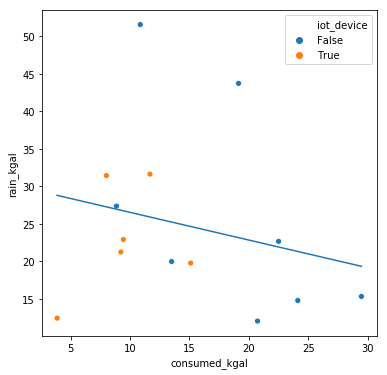

In [16]:
fig, ax = plt.subplots(figsize=(6,6))

sns.scatterplot(x='consumed_kgal', y='rain_kgal', hue='iot_device', data=iot_month_data, ax=ax)
sns.lineplot(x='consumed_kgal'
                 , y=getPoly(iot_month_data.consumed_kgal
                            , iot_month_data.consumed_kgal
                            , iot_month_data.rain_kgal)
                 , data=iot_month_data)
plt.show()

### Data comparison across years

Here I compare the % rain and consumed gallons during the same month across all years of data.

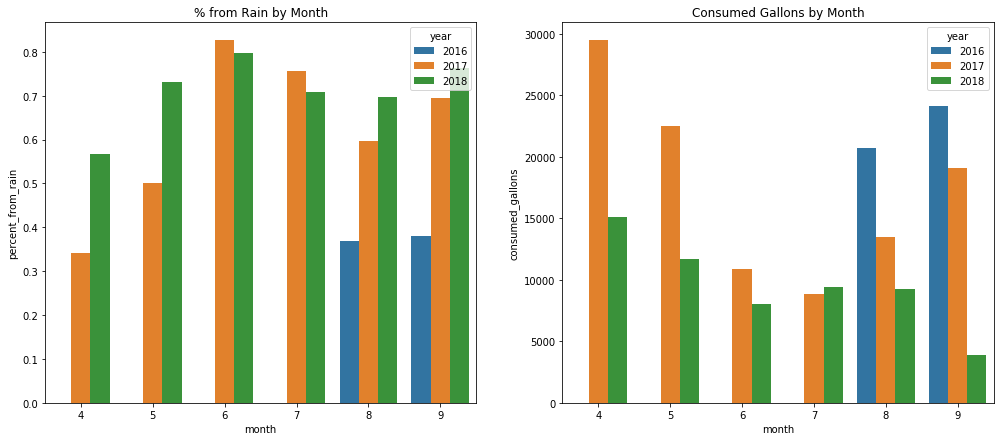

In [17]:
plt.figure(figsize=(17,7))

plt.subplot(121)
plt.title('% from Rain by Month')
sns.barplot(x="month", y="percent_from_rain", hue="year", data=iot_month_data)

plt.subplot(122)
plt.title('Consumed Gallons by Month')
sns.barplot(x="month", y="consumed_gallons", hue="year", data=iot_month_data)
plt.show()

### What-if Scenarios

The left one shows predicted consumption based on the IOT trend, i.e. how much consumption would have been if an IOT device were used instead of the original device.

The right one shows predicted consumption based on the non-IOT trend, i.e. how much consumption would have been if an IOT device were never used.

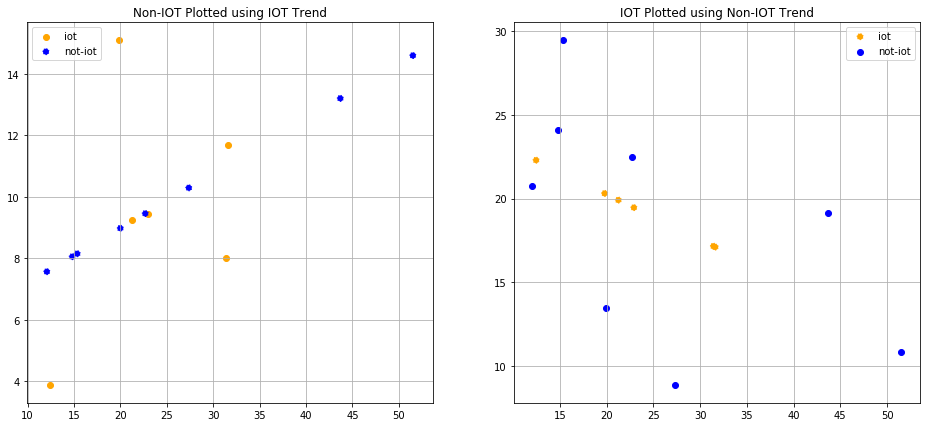

In [18]:
plt.figure(figsize=(16,7))

plt.subplot(121)
plt.title('Non-IOT Plotted using IOT Trend')
plt.grid(True)
a = plt.scatter(iot_month_data_isiot.rain_kgal, iot_month_data_isiot.consumed_kgal, c='Orange')
b = plt.scatter(iot_month_data_notiot.rain_kgal
                , getPoly(iot_month_data_notiot.rain_kgal, iot_month_data_isiot.rain_kgal, iot_month_data_isiot.consumed_kgal)
                , linestyle=':', c='Blue')
plt.legend((a, b), ('iot', 'not-iot'))

plt.subplot(122)
plt.title('IOT Plotted using Non-IOT Trend')
plt.grid(True)
a = plt.scatter(iot_month_data_notiot.rain_kgal, iot_month_data_notiot.consumed_kgal, c='Blue')
b = plt.scatter(iot_month_data_isiot.rain_kgal
                , getPoly(iot_month_data_isiot.rain_kgal, iot_month_data_notiot.rain_kgal, iot_month_data_notiot.consumed_kgal)
                , linestyle=':', c='Orange')
plt.legend((b, a), ('iot', 'not-iot'))

plt.show()

### What savings were realized vs. not?

Since I have predictions on what would have been in each case:

1. IOT device never installed
1. IOT device installed earlier

I can use that to predict any savings that were realized or not realized depending on the scenario.

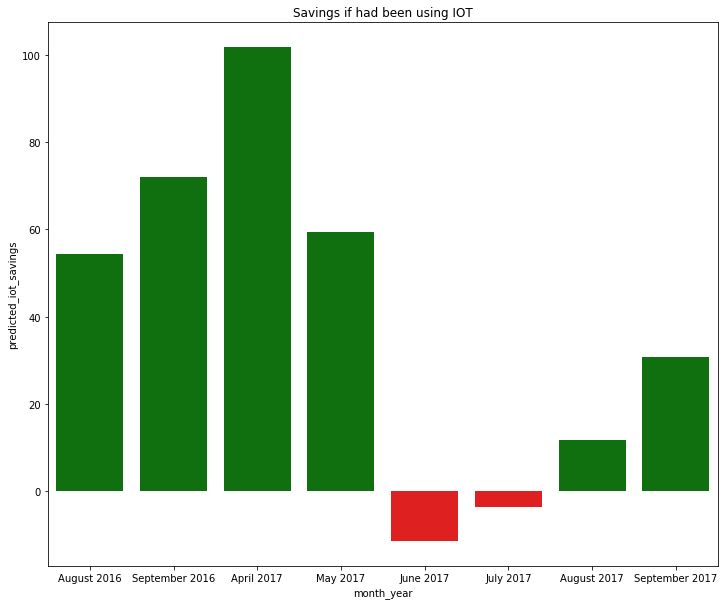

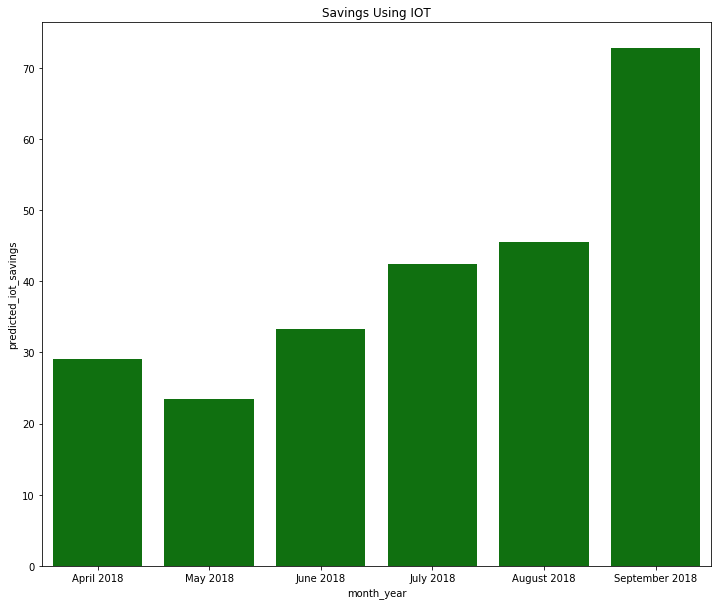

In [19]:
plt.figure(figsize=(12,10))

sns.barplot(x='month_year', y='predicted_iot_savings', data=iot_month_data_notiot, palette=iot_month_data_notiot.predicted_iot_savings.apply(lambda x: 'r' if x < 0 else 'g'))
plt.title('Savings if had been using IOT')
plt.show()

plt.figure(figsize=(12,10))
sns.barplot(x='month_year', y='predicted_iot_savings', data=iot_month_data_isiot, palette=iot_month_data_isiot.predicted_iot_savings.apply(lambda x: 'r' if x < 0 else 'g'))
plt.title('Savings Using IOT')
plt.show()

In [20]:
print("Money saved with IOT: %.2f" % iot_month_data_isiot.predicted_iot_savings.sum())
print("Money lost without IOT: %.2f" % iot_month_data_notiot.predicted_iot_savings.sum())

Money saved with IOT: 246.45
Money lost without IOT: 315.08


In [21]:
# Write the dataframes out to a file use outside of this notebook
combined_df.to_csv('combined_df.csv')

iot_month_data_isiot.to_csv('iot_month_data_isiot.csv')
iot_month_data_notiot.to_csv('iot_month_data_notiot.csv')